In [29]:
# %%

# import math # roundは組み込み関数のため不要
# jax関連のライブラリを全てインポート
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap

# from LikelihoodEvaluator import LikelihoodEvaluator
# from ParameterEstimator import ParameterEstimator
from sympy import Array, symbols

from degenerate_sim import (
    DegenerateDiffusionProcess,
    LikelihoodEvaluator,
    m_estimate,
    newton_solve,
)
from degenerate_sim.evaluation.likelihood_evaluator_jax import SymbolicPreparationError

x_sym, y_sym = symbols("x, y")
theta_10, theta_20, theta_21 = symbols("theta_10 theta_20 theta_21")
theta_30, theta_31 = symbols("theta_30 theta_31")

# ベクトル化（1次元テンソルとして）
x = Array([x_sym])
y = Array([y_sym])
theta_1 = Array([theta_10])
theta_2 = Array([theta_20, theta_21])
theta_3 = Array([theta_30, theta_31])

# Step 2: A, B, H の式定義
A = Array([theta_20 * y_sym - x_sym + theta_21])
B = Array([[theta_10]])
H = Array([(y_sym - y_sym**3 - x_sym + theta_31) / theta_30])

# インスタンス
FNmodel = DegenerateDiffusionProcess(
    x=x,
    y=y,
    theta_1=theta_1,
    theta_2=theta_2,
    theta_3=theta_3,
    A=A,
    B=B,
    H=H,
)

# Likelihood_FN = LikelihoodEvaluator(FNmodel)

In [30]:
true_theta1 = jnp.array([0.3])
true_theta2 = jnp.array([1.5, 0.8])
true_theta3 = jnp.array([0.1, 0.0])
true_theta = (true_theta1, true_theta2, true_theta3)
t_max = 10
burn_out = 50
h = 0.05
bounds_theta1 = [(0.1, 0.5)]
bounds_theta2 = [(0.5, 2.5), (0.5, 1.5)]
bounds_theta3 = [(0.01, 0.3), (-1, 1)]

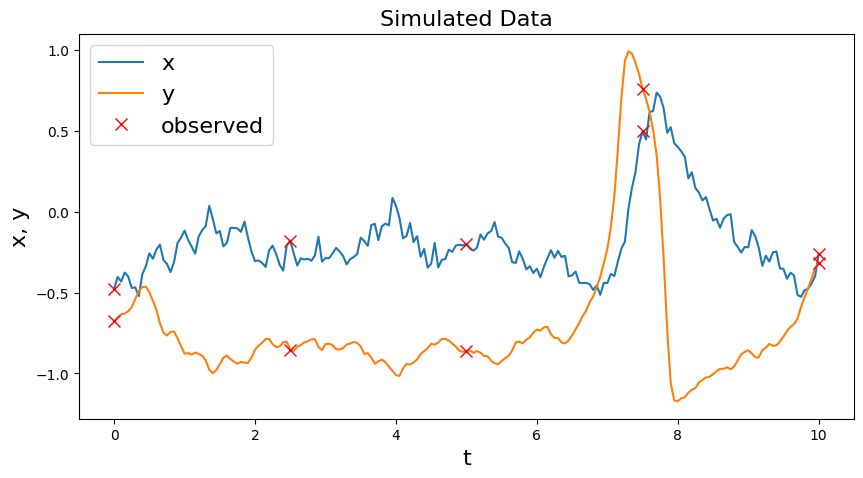

In [31]:
x_series, y_series = FNmodel.simulate(true_theta=true_theta, t_max=t_max, burn_out=burn_out, h=h)
t = jnp.linspace(0, t_max, len(x_series))
plt.figure(figsize=(10, 5))
plt.plot(t, x_series, label="x")
plt.plot(t, y_series, label="y")
plt.xlabel("t", fontsize=16)
plt.ylabel("x, y", fontsize=16)
plt.title("Simulated Data", fontsize=16)
# 5秒間隔で縦線をプロット
# 5秒間隔でグラフ上の点に大きなまるを表示
for i in range(0, len(t), 50):
    if i == 0:
        plt.plot(t[i], x_series[i], "x", color="red", markersize=8, label="observed")
        plt.plot(t[i], y_series[i], "x", color="red", markersize=8)
    else:
        plt.plot(t[i], x_series[i], "x", color="red", markersize=8)
        plt.plot(t[i], y_series[i], "x", color="red", markersize=8)
plt.legend(fontsize=16)
plt.show()

In [32]:
FN_likelihood = LikelihoodEvaluator(FNmodel)


In [33]:
k  = 6
v1 = FN_likelihood.make_quasi_likelihood_v1_evaluator(
    x_series=x_series, y_series=y_series, h=h, k=k
)
v1_prime = FN_likelihood.make_quasi_likelihood_v1_prime_evaluator(
    x_series=x_series, y_series=y_series, h=h, k=k
)
v2 = FN_likelihood.make_quasi_likelihood_v2_evaluator(
    x_series=x_series, y_series=y_series, h=h, k=k
)
v3 = FN_likelihood.make_quasi_likelihood_v3_evaluator(
            x_series=x_series, y_series=y_series, h=h, k=k
        )

In [34]:
def objective_func_1p(theta1_vec: jnp.ndarray) -> jnp.ndarray:
    return v1_prime(theta1_vec, true_theta1, true_theta2, true_theta3)
def objective_func_1(theta1_vec: jnp.ndarray) -> jnp.ndarray:
    return v1(theta1_vec, true_theta1, true_theta2, true_theta3)
def objective_func_2(theta2_vec: jnp.ndarray) -> jnp.ndarray:
    return v2(theta2_vec, true_theta1, theta2_vec, true_theta3)
def objective_func_3(theta3_vec: jnp.ndarray) -> jnp.ndarray:
    return v3(theta3_vec, true_theta1, true_theta2, true_theta3)

In [37]:
est_1p = m_estimate(
    objective_function=objective_func_1p, search_bounds=bounds_theta1, initial_guess=jnp.array([0.2])
)
print(est_1p)
# est_1 = m_estimate(
#     objective_function=objective_func_1, search_bounds=bounds_theta1, initial_guess=jnp.array([0.2])
# )
# print(est_1)
est_2 = m_estimate(
    objective_function=objective_func_2,
    search_bounds=bounds_theta2,
    initial_guess=jnp.array([0.5, 0.5]),
)
print(est_2)
if v3 is not None:
    est_3 = m_estimate(
        objective_function=lambda th: v3(th, true_theta1, true_theta2, true_theta3),
        search_bounds=bounds_theta3,
        initial_guess=jnp.array([0.2, 0.1]),
    )
    print(est_3)
else:
    est_3 = None
    print("Skipped v3 M-estimation because the evaluator is unavailable.")


[0.28865615]
[1.2381202  0.70355487]
[0.10004818 0.00086664]


In [8]:
est_1_newton = newton_solve(
    objective_function=objective_func_1,
    search_bounds=bounds_theta1,
    initial_guess=jnp.array([0.2]),
    damping=0.5,
    log_interval=5,
)
print(est_1_newton)
est_2_newton = newton_solve(
    objective_function=objective_func_2,
    search_bounds=bounds_theta2,
    initial_guess=jnp.array([0.5, 0.5]),
    damping=0.5,
    log_interval=5,
)
print(est_2_newton)
if v3 is not None:
    est_3_newton = newton_solve(
        objective_function=objective_func_3,
        search_bounds=bounds_theta3,
        initial_guess=jnp.array([0.1, 0.0]),
        damping=0.5,
        log_interval=5,
    )
    print(est_3_newton)
else:
    est_3_newton = None
    print("Skipped v3 Newton solve because the evaluator is unavailable.")


[newton_solve] iter=5 grad_norm=3.898e+00 theta=[0.5]
[newton_solve] iter=10 grad_norm=3.898e+00 theta=[0.5]
[newton_solve] iter=15 grad_norm=3.898e+00 theta=[0.5]
[newton_solve] iter=20 grad_norm=3.898e+00 theta=[0.5]
[newton_solve] iter=25 grad_norm=3.898e+00 theta=[0.5]
[newton_solve] iter=30 grad_norm=3.898e+00 theta=[0.5]
[newton_solve] iter=35 grad_norm=3.898e+00 theta=[0.5]
[newton_solve] iter=40 grad_norm=3.898e+00 theta=[0.5]
[newton_solve] iter=45 grad_norm=3.898e+00 theta=[0.5]
[newton_solve] iter=50 grad_norm=3.898e+00 theta=[0.5]
[0.5]
[newton_solve] iter=5 grad_norm=3.927e-01 theta=[1.5261211 0.8547273]
[newton_solve] iter=10 grad_norm=1.228e-02 theta=[1.5944694 0.8785986]
[newton_solve] iter=15 grad_norm=3.843e-04 theta=[1.5966096 0.8793466]
[newton_solve] iter=20 grad_norm=1.262e-05 theta=[1.5966763  0.87936985]
[1.5966784  0.87937057]
[newton_solve] iter=5 grad_norm=1.932e-02 theta=[9.943676e-02 4.198649e-05]
[newton_solve] iter=10 grad_norm=6.030e-04 theta=[9.9401675e

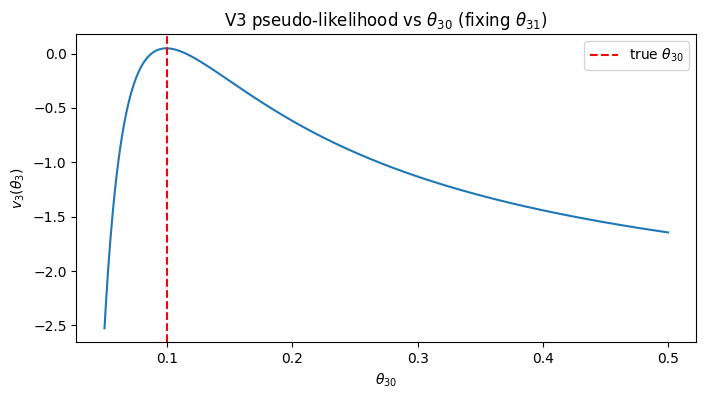

In [9]:
if v3 is None:
    print("V3 evaluator unavailable; skipping grid evaluation.")
else:
    theta30_grid = jnp.linspace(0.05, 0.5, 2000)  # 必要に応じて範囲を変更
    theta31_fixed = -9.359051e-06

    def v3_wrapper(theta30):
        theta3_vec = jnp.array([theta30, theta31_fixed])
        return v3(theta3_vec, true_theta1, true_theta2, true_theta3)

    v3_grid = vmap(v3_wrapper)(theta30_grid)

    plt.figure(figsize=(8, 4))
    plt.plot(theta30_grid, v3_grid)
    plt.axvline(true_theta3[0], color="red", linestyle="--", label=r"true $\theta_{30}$")
    plt.xlabel(r"$\theta_{30}$")
    plt.ylabel(r"$v_3(\theta_3)$")
    plt.title(r"V3 pseudo-likelihood vs $\theta_{30}$ (fixing $\theta_{31}$)")
    plt.legend()
    plt.show()
